In [170]:
import cv2
import glob
import tqdm
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
images_names = glob.glob("../../images/RGB/*")
print len(images_names)

6


In [117]:
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')

In [161]:
def get_RGB_matrix(image):
    
    redbox = [270, 330, 170, 230]
    greenbox = [270, 330, 420, 480]
    bluebox = [270, 330, 670, 730]
    
    matrix = np.ones((3, 3))
    
    for j, (color, box) in enumerate(zip(['red', 'green', 'blue'], [redbox, greenbox, bluebox])):
        matrix[:, j] = image[box[0] : box[1], box[2] : box[3], :].mean(axis=(0,1))
        
    return matrix

In [162]:
def apply_correction(image, A):
    image_corrected = np.zeros_like(image)
    for j in xrange(image.shape[0]):
        for i in xrange(image.shape[1]):
            image_corrected[j, i, :] = A.dot(image[j, i, :].reshape((3, 1))).reshape((3,))
    image_corrected[image_corrected >= 255.] = 255
    image_corrected[image_corrected <= 0.] = 0
    return image_corrected.astype(np.uint8)

../../images/RGB/IMG_20170814_183411.jpg (639, 921, 3)
[[ 217.3075       56.08         67.16361111]
 [  82.92777778  125.12861111  110.36027778]
 [  75.96694444   62.45861111  129.59833333]]


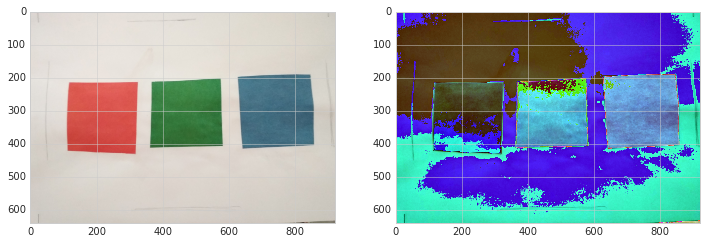

../../images/RGB/IMG_20170814_183455.jpg (623, 864, 3)
[[ 165.65555556   36.64111111   35.51555556]
 [  50.905        89.84861111   68.03777778]
 [  35.54388889   31.19777778   86.28277778]]


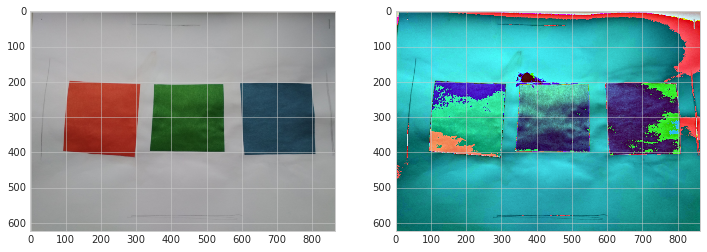

../../images/RGB/IMG_20170814_183448.jpg (622, 877, 3)
[[ 218.96611111   38.44722222   37.3525    ]
 [  77.19055556  127.83111111   87.69      ]
 [  57.74777778   43.37611111  109.44888889]]


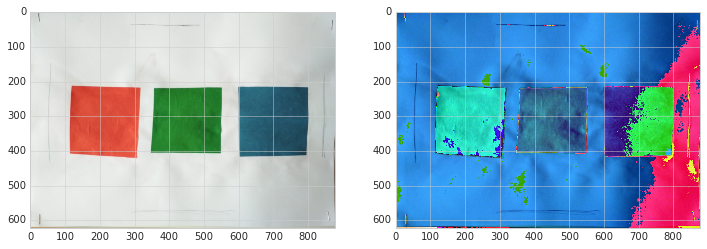

../../images/RGB/IMG_20170814_183428.jpg (636, 886, 3)
[[ 224.67333333   47.98388889   62.58055556]
 [  77.10666667  129.13666667  118.88277778]
 [  63.4975       57.6175      143.07944444]]


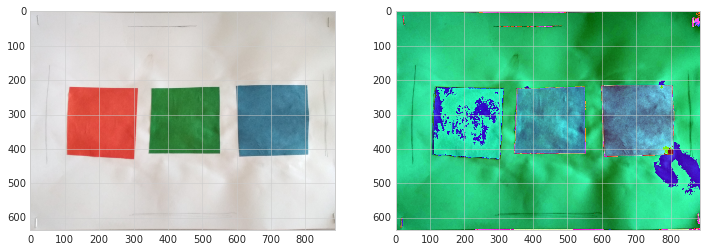

../../images/RGB/IMG_20170814_183437.jpg (661, 974, 3)
[[ 215.25944444   42.72138889   46.83638889]
 [  74.55972222  128.48222222   99.22611111]
 [  58.2825       48.55138889  120.90833333]]


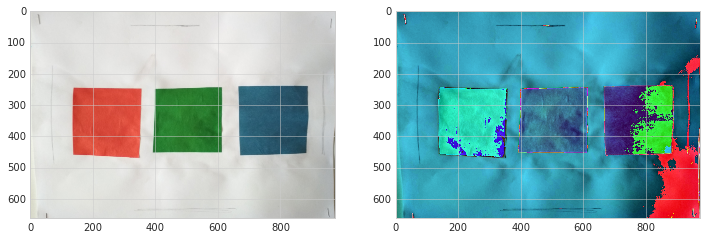

../../images/RGB/IMG_20170814_183538.jpg (650, 917, 3)
[[ 195.98194444   47.85944444   71.76722222]
 [  76.19361111  118.51333333  116.95166667]
 [  64.535        57.97777778  147.91444444]]


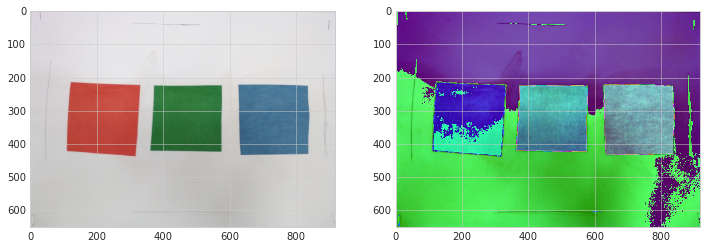

In [163]:
for image_name in images_names:
        
    image = cv2.imread(image_name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.pyrDown(image)
    image = cv2.pyrDown(image)
    
    print image_name, image.shape
    
    rgb = get_RGB_matrix(image)
    print rgb
    
    A = (255 * np.eye(3)) * np.linalg.inv(rgb)
    A[A <= 0.] = 0.
    A[A >= 255.] = 255.
#     print A
    
    image_corrected = apply_correction(image, A)
    
    rgb_ = get_RGB_matrix(image_corrected)
#     print rgb_
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(image_corrected)
    plt.show()

Замутим регрессию:

In [149]:
def get_RGBs(image):
    
    redbox = [270, 330, 170, 230]
    greenbox = [270, 330, 420, 480]
    bluebox = [270, 330, 670, 730]
    entries = []

    for k, (color, box) in enumerate(zip(['red', 'green', 'blue'], [redbox, greenbox, bluebox])):
        crop = image[box[0] : box[1], box[2] : box[3], :]
        for i in xrange(60):
            for j in xrange(60):
                entries.append({'color': color,
                                'r' : crop[i, j, 0],
                                'g' : crop[i, j, 1],
                                'b' : crop[i, j, 2]})
        plt.imshow(crop)
        plt.show()
                
    return entries 

../../images/RGB/IMG_20170814_183411.jpg (639, 921, 3)


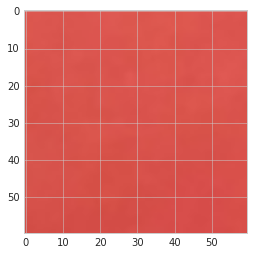

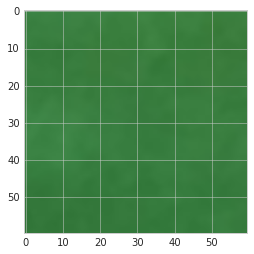

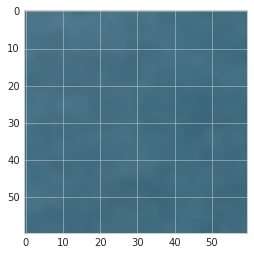

10800
../../images/RGB/IMG_20170814_183455.jpg (623, 864, 3)


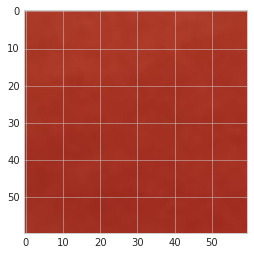

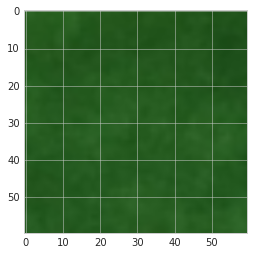

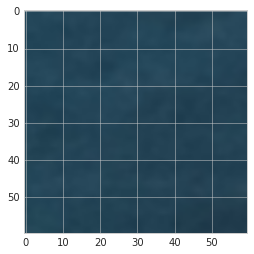

10800
../../images/RGB/IMG_20170814_183448.jpg (622, 877, 3)


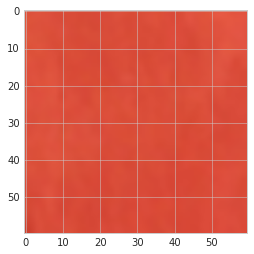

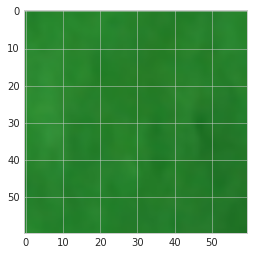

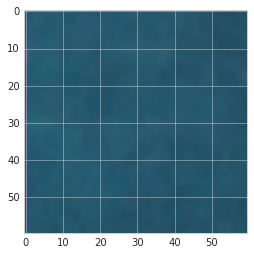

10800
../../images/RGB/IMG_20170814_183428.jpg (636, 886, 3)


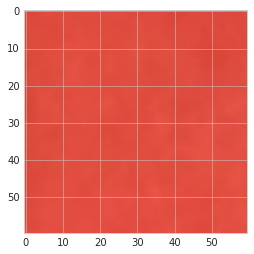

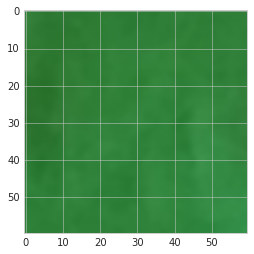

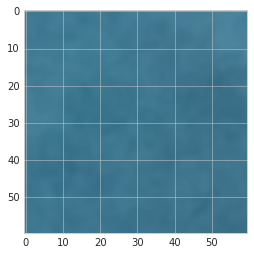

10800
../../images/RGB/IMG_20170814_183437.jpg (661, 974, 3)


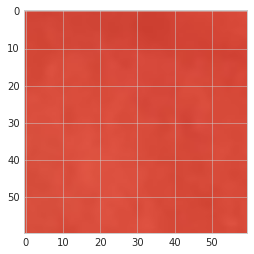

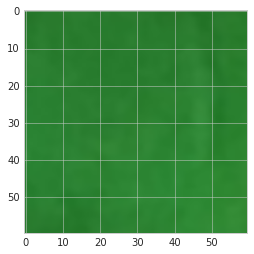

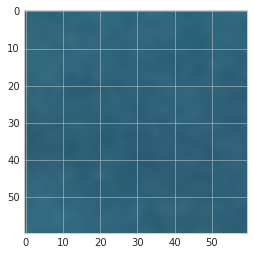

10800
../../images/RGB/IMG_20170814_183538.jpg (650, 917, 3)


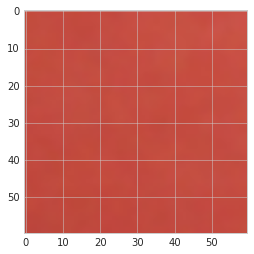

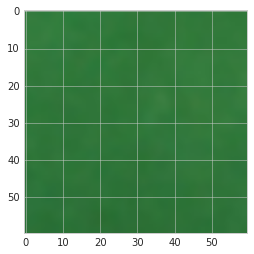

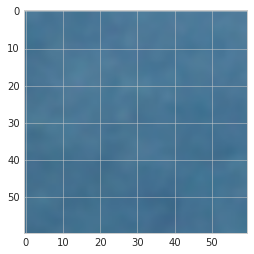

10800


In [150]:
df = pd.DataFrame(columns=['r', 'g', 'b', 'color'])
for image_name in images_names:
        
    image = cv2.imread(image_name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.pyrDown(image)
    image = cv2.pyrDown(image)
    
    print image_name, image.shape
    entries = get_RGBs(image)
    print len(entries)
    df = df.append(entries)
    
df.to_csv("rgb.csv", sep=';')

In [151]:
df['r'] = df['r'].map(int)
df['g'] = df['g'].map(int)
df['b'] = df['b'].map(int)

In [152]:
X = df[['r', 'g', 'b']].values

In [153]:
y = df['color'].map({'red' : 0, 'green' : 1, 'blue' : 2}).values

In [154]:
X.shape, y.shape

((64800, 3), (64800,))

In [155]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [156]:
lr = LogisticRegression(n_jobs=4)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3)

In [157]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [160]:
print(accuracy_score(y_test, lr.predict(X_test)))

1.0


In [192]:
def apply_color(rgb, model):
    r_, g_, b_ = 255 * model.predict_proba(rgb.reshape((-1, 3)))[0]
    return np.array([r_, g_, b_])

[  1.99522585e-07   1.19555833e-09   9.99999799e-01]


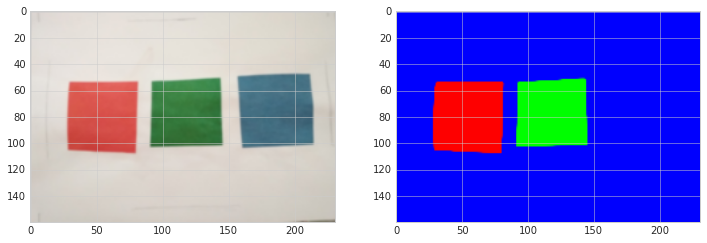

[  2.27543474e-06   2.78947026e-08   9.99997697e-01]


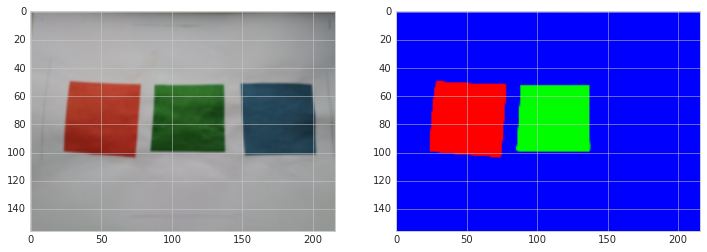

[  6.86237611e-08   1.46214156e-09   9.99999930e-01]


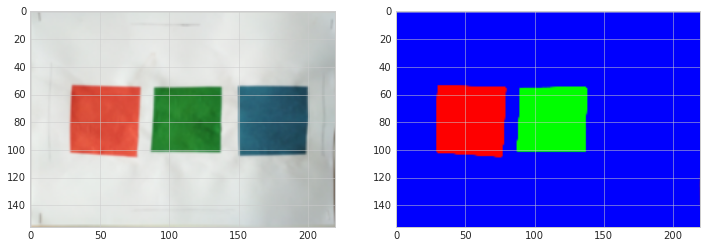

[  1.33669013e-07   4.17883485e-10   9.99999866e-01]


KeyboardInterrupt: 

In [193]:
for image_name in images_names:
        
    image = cv2.imread(image_name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.pyrDown(image)
    image = cv2.pyrDown(image)
    image = cv2.pyrDown(image)
    image = cv2.pyrDown(image)
    image_colored = np.zeros_like(image)
    
    for i in xrange(image.shape[0]):
        for j in xrange(image.shape[1]):
            rgb = image[i, j, :].ravel()
            if i == 20 and j == 20:
                print lr.predict_proba(rgb.reshape((-1, 3)))[0]
            image_colored[i, j, :] = apply_color(rgb, lr)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(image_colored)
    plt.show()

In [197]:
lr.coef_

array([[ 0.13042283, -0.13544084, -0.06851569],
       [-0.07320224,  0.2483957 , -0.27156473],
       [-0.07295275, -0.19678612,  0.29106129]])